# ノートブック05: 決定木とアンサンブル - 複雑なパターンを学習する 🌳

**学習目標**: 決定木、Random Forest、Gradient Boostingの基礎を完全にマスターし、実データで適用できるようになる

---

## 📋 このノートブックで学ぶこと

### 1. 決定木の基礎 ⭐⭐⭐
- 決定木のアルゴリズム（CART）
- 情報利得とGini不純度の違い
- 木の深さと過学習の関係
- 決定木の可視化と解釈
- 剪定（Pruning）の概念

### 2. Random Forest（ランダムフォレスト） ⭐⭐⭐
- バギング（Bootstrap Aggregating）の仕組み
- ランダム特徴量選択
- Out-of-Bag（OOB）スコア
- 特徴量重要度の計算方法
- ハイパーパラメータの調整

### 3. Gradient Boosting基礎 ⭐⭐
- ブースティングの基本概念
- 残差学習の仕組み
- 学習率（learning_rate）の役割
- scikit-learnのGradientBoosting
- Random ForestとGradient Boostingの違い

### 4. 実践的な応用 ⭐⭐⭐
- 医療診断データでの分類
- モデルの比較と選択
- Cross-Validationによる評価
- 特徴量重要度の分析

---

## 🎯 達成目標

このノートブックを完了すると：
- ✅ 決定木の仕組みを完全に理解できる
- ✅ Random Forestを実装・最適化できる
- ✅ Gradient Boostingの基礎を理解できる
- ✅ 適切なアンサンブル手法を選択できる
- ✅ 実データで高精度なモデルを構築できる

**Note**: より高度なGBDT（LightGBM、XGBoost、CatBoost）はノートブック13-16で詳しく学びます

---

⏱️ **推定学習時間**: 120-150分  
📊 **難易度**: ★★★☆☆（中級）

---

## 🔧 1. セットアップ

In [18]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# 機械学習
from sklearn.datasets import (
    make_classification, 
    make_moons, 
    load_breast_cancer,
    load_wine
)
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    cross_val_score,
    learning_curve
)
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    BaggingClassifier
)

# 設定
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)

# 再現性のためのシード
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ セットアップ完了")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


✅ セットアップ完了
NumPy version: 2.3.5
Pandas version: 2.3.3
Japanese font: Hiragino Sans


## 🌲 2. 決定木の基礎

### 決定木とは？

決定木（Decision Tree）は、データを**if-thenルール**で分類・予測するモデルです。

**例**: タイタニック号の生存予測
```
性別は女性?
├─ Yes → 年齢 < 30?
│         ├─ Yes → 生存
│         └─ No  → 生存
└─ No  → チケットクラス = 1?
          ├─ Yes → 生存
          └─ No  → 死亡
```

---

### 📊 決定木は分類にも回帰にも使える！

決定木は**分類問題**だけでなく**回帰問題**（連続値の予測）にも使えます。
scikit-learnでは：
- 分類: `DecisionTreeClassifier`
- 回帰: `DecisionTreeRegressor`

#### 分類と回帰の違い

| 観点 | 分類（Classification） | 回帰（Regression） |
|------|----------------------|-------------------|
| **目的** | カテゴリを予測 | 連続値を予測 |
| **葉ノードの予測値** | 多数決クラス | サンプルの平均値 |
| **分割基準** | Gini不純度 or エントロピー | MSE（二乗誤差） |
| **評価指標** | Accuracy, F1 | MSE, RMSE, R² |

---

### 🎯 回帰木（Regression Tree）の仕組み

#### 具体例: 住宅価格の予測

```
データ: 10軒の住宅
  面積: [50, 60, 70, 80, 90, 100, 110, 120, 130, 140] m²
  価格: [1000, 1200, 1400, 1600, 1800, 3000, 3200, 3400, 3600, 3800] 万円

【分岐なし（全体の平均）】
  予測 = 平均 = 2400万円
  MSE = ((1000-2400)² + (1200-2400)² + ... + (3800-2400)²) / 10
      = 1,160,000  ← 誤差が大きい

【面積 < 95m² で分岐】
  左の子（面積 < 95m²）: [1000, 1200, 1400, 1600, 1800]
    予測 = 平均 = 1400万円
    MSE = 80,000
    
  右の子（面積 >= 95m²）: [3000, 3200, 3400, 3600, 3800]
    予測 = 平均 = 3400万円
    MSE = 80,000

  全体のMSE = (5/10)×80,000 + (5/10)×80,000 = 80,000
  
  → 分岐でMSEが 1,160,000 → 80,000 に大幅減少！
```

#### 回帰木の分割基準: MSE（Mean Squared Error）の最小化

$$MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \bar{y})^2$$

- $y_i$: 各サンプルの実際の値
- $\bar{y}$: ノード内のサンプルの平均値

**分岐の評価**:
$$\text{MSE削減量} = MSE_{親} - \frac{N_{左}}{N}MSE_{左} - \frac{N_{右}}{N}MSE_{右}$$

→ MSE削減量が最大になる分岐点を選ぶ！

---

### 🌳 回帰木の予測の仕組み

```
訓練後の木:
                [全データ: 平均2400万]
                        |
              面積 < 95m² ?
              /           \
    [平均1400万]         [平均3400万]
         |                    |
    築年数 < 10?         駅距離 < 5分?
    /        \           /         \
[1200万]  [1600万]  [3600万]    [3200万]

新しいデータの予測:
  面積: 85m², 築年数: 15年
  
  1. 面積 < 95m²? → Yes → 左へ
  2. 築年数 < 10? → No → 右へ
  3. 葉ノードに到達 → 予測 = 1600万円
```

**重要なポイント**:
- 葉ノードの予測値 = そのノードに属する**訓練サンプルの平均値**
- 分類のように多数決ではなく、**平均**を取る
- 新しいデータは木を辿って葉ノードに到達し、その平均値が予測値

---

### 🔑 決定木はどうやって学習するのか？（分類の場合）

決定木の学習は「**最適な分岐を見つける**」ことの繰り返しです。

#### ステップ1: 最適な分岐の探索

すべての特徴量とすべての閾値について、「分岐後にどれだけデータが綺麗に分かれるか」を計算します。

```
例: 100人のデータ（50人が陽性、50人が陰性）

候補1: 年齢 < 30 で分岐
  ├─ 30歳未満: 40人（陽性35, 陰性5）  ← かなり綺麗に分かれた！
  └─ 30歳以上: 60人（陽性15, 陰性45） ← こちらも綺麗

候補2: 収入 < 500万 で分岐
  ├─ 500万未満: 50人（陽性25, 陰性25） ← 全然分かれてない...
  └─ 500万以上: 50人（陽性25, 陰性25） ← 同じく...

→ 候補1（年齢 < 30）の方が良い分岐！
```

#### ステップ2: 「綺麗に分かれる」の定量化 = 不純度

「綺麗に分かれる」を数値で測るのが**不純度（Impurity）**です。

**Gini不純度**:
$$Gini = 1 - \sum_{i=1}^{C} p_i^2$$

```
例: 40人のノード（陽性35人、陰性5人）
  p_陽性 = 35/40 = 0.875
  p_陰性 = 5/40 = 0.125
  
  Gini = 1 - (0.875² + 0.125²)
       = 1 - (0.766 + 0.016)
       = 0.219  ← 低い = 綺麗に分かれている！

例: 50人のノード（陽性25人、陰性25人）
  Gini = 1 - (0.5² + 0.5²)
       = 1 - 0.5
       = 0.5  ← 高い = バラバラ（最悪）
```

#### ステップ3: 情報利得（Information Gain）の計算

分岐前後でどれだけ不純度が減ったかを計算します。

$$\text{Information Gain} = \text{親の不純度} - \text{子の不純度の加重平均}$$

```
分岐前: 100人（Gini = 0.5）

年齢 < 30 で分岐後:
  左の子: 40人（Gini = 0.219）
  右の子: 60人（Gini = 0.375）
  
  子の加重平均 = (40/100)×0.219 + (60/100)×0.375
               = 0.088 + 0.225 = 0.313
  
  情報利得 = 0.5 - 0.313 = 0.187  ← これが最大になる分岐を選ぶ！
```

#### ステップ4: 再帰的に木を構築

```
1. ルートノード: 全データで最適な分岐を見つける
2. 左の子: 条件を満たすデータで最適な分岐を見つける
3. 右の子: 条件を満たさないデータで最適な分岐を見つける
4. 各子ノードでも同様に繰り返す（再帰）
5. 停止条件に達したら葉ノードとする
```

#### 停止条件

以下のいずれかで分岐を停止し、葉ノードとします：

- `max_depth`: 木の深さが上限に達した
- `min_samples_split`: ノードのサンプル数が閾値以下
- `min_samples_leaf`: 子ノードのサンプル数が閾値以下
- ノードが純粋（1クラスのみ）になった
- これ以上情報利得が得られない

---

### 📈 分類 vs 回帰: 分割基準の比較

| 問題タイプ | 分割基準 | 意味 |
|-----------|---------|------|
| **分類** | Gini不純度 | クラスの混在度を測る |
| **分類** | エントロピー | 情報理論的な不確実性 |
| **回帰** | MSE（二乗誤差） | 予測値からのばらつき |
| **回帰** | MAE（絶対誤差） | 外れ値に強い |

```python
# 分類の場合
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini')  # or 'entropy'

# 回帰の場合
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(criterion='squared_error')  # or 'absolute_error'
```

---

### 決定木の利点と欠点

**利点** ✅:
- 解釈しやすい（ビジネスルールとして使える）
- 特徴量のスケーリング不要
- カテゴリカル変数を直接扱える
- 非線形な関係をモデル化できる
- 欠損値にロバスト
- **分類と回帰の両方に使える**

**欠点** ❌:
- 過学習しやすい
- 少しのデータ変化で木構造が大きく変わる（不安定）
- 線形な関係の表現が苦手
- 貪欲法なので、大域的最適解は保証されない
- **回帰の場合、予測値が離散的（階段状）になる**

### 分割基準の比較（分類）

#### 1. Gini不純度（Gini Impurity）
$$Gini = 1 - \sum_{i=1}^{C} p_i^2$$

- 計算が速い
- scikit-learnのデフォルト

#### 2. エントロピー（Entropy）
$$H = -\sum_{i=1}^{C} p_i \log_2(p_i)$$

- 情報理論に基づく
- Giniより少し計算が遅い
- 実務ではGiniとほぼ同じ結果

**どちらを使うべき？** → 実務ではどちらでもOK（Giniがデフォルト）

### 2.1 シンプルな例：2次元分類

📊 データ情報:
   訓練データ: 210 samples
   テストデータ: 90 samples
   特徴量数: 2
   クラス分布: [150 150]


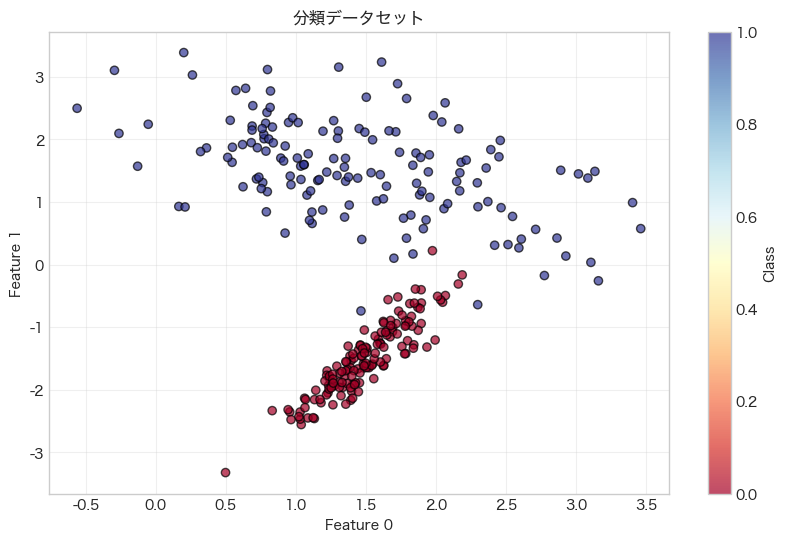

In [19]:
# シンプルな2クラス分類データ生成
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.5,
    random_state=RANDOM_STATE
)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

print("📊 データ情報:")
print(f"   訓練データ: {X_train.shape[0]} samples")
print(f"   テストデータ: {X_test.shape[0]} samples")
print(f"   特徴量数: {X.shape[1]}")
print(f"   クラス分布: {np.bincount(y)}")

# データの可視化
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black', alpha=0.7)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('分類データセット')
plt.colorbar(label='Class')
plt.grid(True, alpha=0.3)
plt.show()

### 2.2 決定木モデルの訓練

In [20]:
# 決定木モデル（深さ制限あり）
dt = DecisionTreeClassifier(
    max_depth=3,
    criterion='gini',  # 'gini' or 'entropy'
    random_state=RANDOM_STATE
)
dt.fit(X_train, y_train)

# 予測
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# 評価
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("📊 決定木の結果:")
print(f"\n訓練精度: {train_acc:.3f}")
print(f"テスト精度: {test_acc:.3f}")
print(f"\n木の深さ: {dt.get_depth()}")
print(f"葉の数: {dt.get_n_leaves()}")
print(f"\n詳細レポート:")
print(classification_report(y_test, y_test_pred, target_names=['Class 0', 'Class 1']))

📊 決定木の結果:

訓練精度: 0.995
テスト精度: 0.989

木の深さ: 3
葉の数: 4

詳細レポート:
              precision    recall  f1-score   support

     Class 0       1.00      0.98      0.99        46
     Class 1       0.98      1.00      0.99        44

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



### 2.3 決定木の可視化 ⭐⭐⭐

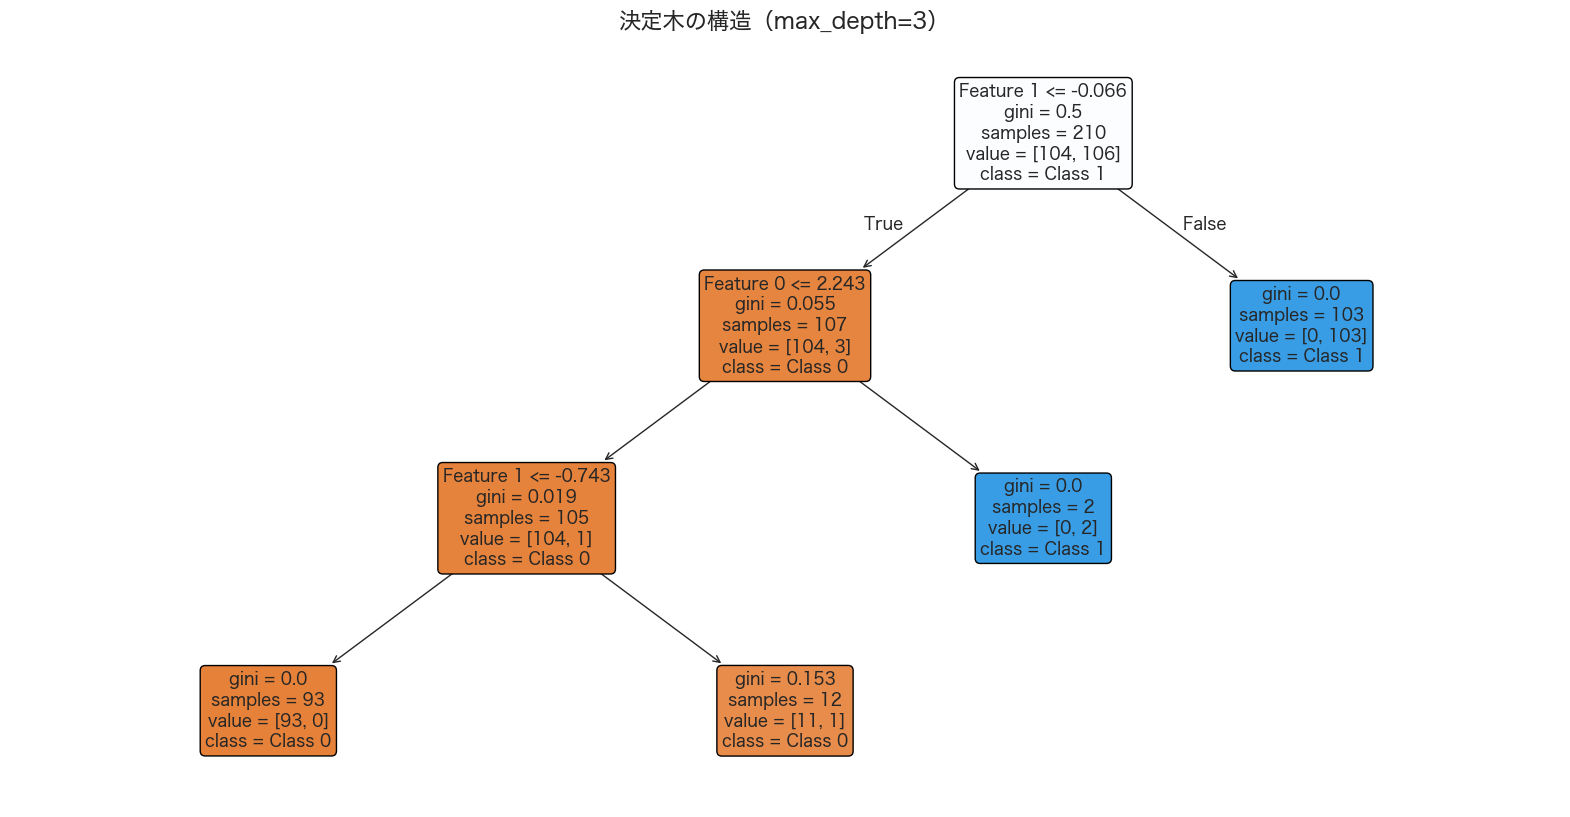


💡 木の読み方:
   - 各ノード: 分割条件
   - gini: Gini不純度
   - samples: サンプル数
   - value: クラスごとのサンプル数
   - class: 多数決クラス


In [21]:
# 木構造の可視化
plt.figure(figsize=(20, 10))
plot_tree(
    dt, 
    feature_names=['Feature 0', 'Feature 1'],
    class_names=['Class 0', 'Class 1'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title('決定木の構造（max_depth=3）', fontsize=16)
plt.show()

print("\n💡 木の読み方:")
print("   - 各ノード: 分割条件")
print("   - gini: Gini不純度")
print("   - samples: サンプル数")
print("   - value: クラスごとのサンプル数")
print("   - class: 多数決クラス")

### 2.4 決定境界の可視化

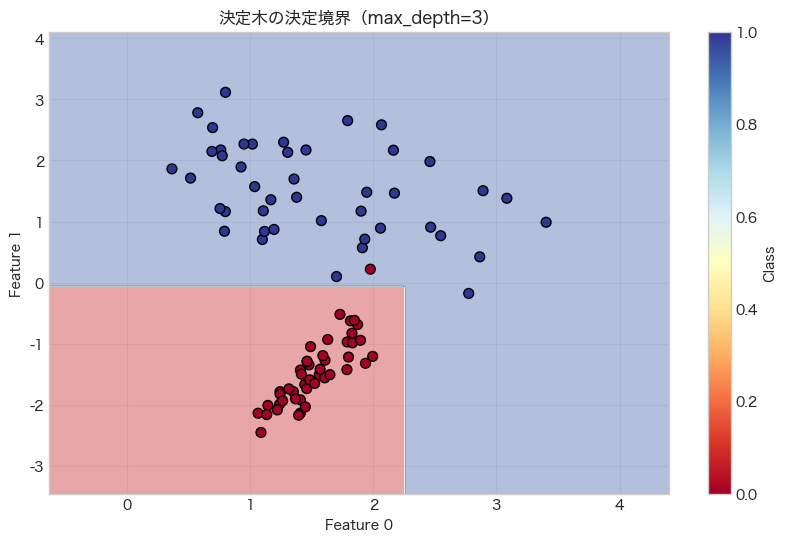


💡 ポイント: 決定木の境界は直線（または平面）の組み合わせ


In [22]:
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    """
    決定境界を可視化する関数
    """
    h = 0.02  # メッシュのステップサイズ
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 各点での予測
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # プロット
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black', s=50)
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)
    plt.colorbar(label='Class')
    plt.grid(True, alpha=0.3)
    plt.show()

# 決定境界を表示
plot_decision_boundary(dt, X_test, y_test, '決定木の決定境界（max_depth=3）')

print("\n💡 ポイント: 決定木の境界は直線（または平面）の組み合わせ")

### 2.5 深さと過学習の関係 ⭐⭐⭐

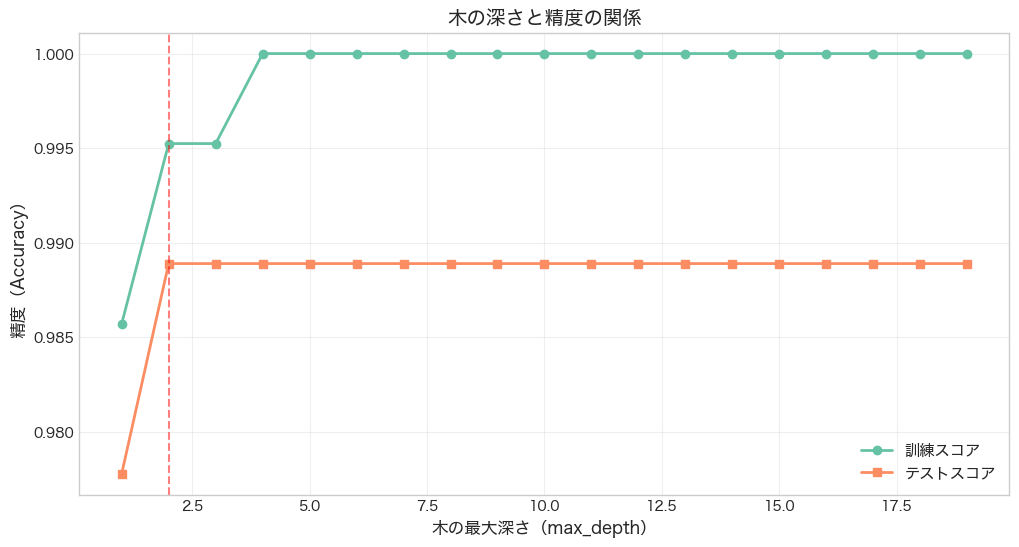


📊 結果:
   最適な深さ: 2
   最高テスト精度: 0.989

💡 重要なポイント:
   - 深さ < 2: 過小学習（underfitting）
   - 深さ = 2: 最適
   - 深さ > 2: 過学習（overfitting）


In [23]:
# 異なる深さで訓練し、精度の変化を観察
max_depths = range(1, 20)
train_scores = []
test_scores = []

for depth in max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    dt_temp.fit(X_train, y_train)
    train_scores.append(dt_temp.score(X_train, y_train))
    test_scores.append(dt_temp.score(X_test, y_test))

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_scores, 'o-', label='訓練スコア', linewidth=2, markersize=6)
plt.plot(max_depths, test_scores, 's-', label='テストスコア', linewidth=2, markersize=6)
plt.xlabel('木の最大深さ（max_depth）', fontsize=12)
plt.ylabel('精度（Accuracy）', fontsize=12)
plt.title('木の深さと精度の関係', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axvline(x=max_depths[np.argmax(test_scores)], color='red', linestyle='--', alpha=0.5, label='最適な深さ')
plt.show()

best_depth = max_depths[np.argmax(test_scores)]
print(f"\n📊 結果:")
print(f"   最適な深さ: {best_depth}")
print(f"   最高テスト精度: {max(test_scores):.3f}")
print(f"\n💡 重要なポイント:")
print(f"   - 深さ < {best_depth}: 過小学習（underfitting）")
print(f"   - 深さ = {best_depth}: 最適")
print(f"   - 深さ > {best_depth}: 過学習（overfitting）")

## 🌲🌲🌲 3. Random Forest（ランダムフォレスト）

### Random Forestとは？

Random Forestは、**複数の決定木を組み合わせる**アンサンブル手法です。
「三人寄れば文殊の知恵」のように、**多数の弱い学習器を組み合わせて強い学習器を作る**のが基本思想です。

---

### 🎯 なぜ複数の木を組み合わせると精度が上がるのか？

#### 単一の決定木の問題点

```
問題1: 過学習しやすい
  - 深い木は訓練データに完璧にフィット
  - しかし新しいデータでは性能が落ちる

問題2: 不安定（高バリアンス）
  - データが少し変わるだけで木構造が大きく変わる
  - 予測結果がデータに敏感すぎる
```

#### 解決策: アンサンブル（集団の知恵）

```
例: 100人に「明日雨が降るか？」と聞く

  - 1人だけに聞く → その人が間違えたらアウト
  - 100人に聞いて多数決 → 多くの人が正しければOK

同様に:
  - 1本の決定木 → 過学習や偶然の間違いに弱い
  - 100本の決定木で多数決 → 個々の間違いが相殺される
```

**数学的な直感**:
- 各木の誤差が独立なら、平均化で誤差の分散が 1/N に減少
- 100本なら分散が1/100に！

---

### 🔑 Random Forestの3つのランダム性

#### 1. バギング（Bootstrap Aggregating）

**ブートストラップサンプリング**: 元データから**重複を許して**ランダムにサンプリング

```
元データ: [A, B, C, D, E]  (5サンプル)

木1用データ: [A, A, C, D, E]  ← Aが2回、Bがない
木2用データ: [B, B, C, D, D]  ← B, Dが重複
木3用データ: [A, C, C, E, E]  ← C, Eが重複
...

各木は少しずつ異なるデータで訓練される
→ 木ごとに異なる視点でデータを見る
```

**なぜ重複を許す？**
- 元データと同じサイズのサンプルを作れる
- 約63.2%のデータが選ばれ、36.8%は選ばれない（OOBデータ）
- 選ばれなかったデータで検証できる（OOBスコア）

#### 2. ランダム特徴量選択

各分岐で**一部の特徴量のみ**をランダムに選んで最適な分割を探す

```
全特徴量: [年齢, 収入, 性別, 職業, 地域, 学歴, ...]  (例: 10個)

木1の分岐1: [年齢, 収入, 職業] から選ぶ  (√10 ≈ 3個)
木1の分岐2: [性別, 地域, 学歴] から選ぶ
木2の分岐1: [収入, 性別, 地域] から選ぶ
...

→ 特定の強い特徴量に依存しすぎない
→ 木同士の相関が下がる（多様性が増す）
```

**特徴量数の目安**:
- 分類: `max_features='sqrt'` (√m個)
- 回帰: `max_features=None` (全特徴量) または `max_features=m/3`

#### 3. 多数決 / 平均

```
分類の場合（多数決）:
  木1: クラスA
  木2: クラスB
  木3: クラスA
  木4: クラスA
  木5: クラスB
  
  → 多数決でクラスA（3票 vs 2票）

回帰の場合（平均）:
  木1: 100
  木2: 95
  木3: 105
  木4: 98
  木5: 102
  
  → 平均で100
```

---

### 📊 Out-of-Bag（OOB）スコアとは？

ブートストラップでは約36.8%のデータが選ばれません。このデータを**OOB（Out-of-Bag）データ**と呼びます。

```
元データ: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

木1: [1,1,3,4,6,7,7,8,9,10] で訓練 → 2,5 がOOB
木2: [2,2,3,4,5,6,8,8,9,10] で訓練 → 1,7 がOOB
木3: [1,3,3,4,5,5,7,8,9,10] で訓練 → 2,6 がOOB
...

サンプル1の予測:
  - 木1では訓練に使われた → 予測しない
  - 木2ではOOB → この木で予測
  - 木3では訓練に使われた → 予測しない
  
サンプル1のOOB予測 = OOBな木での多数決
```

**OOBスコアのメリット**:
- ✅ 検証データを分ける必要がない
- ✅ 全データを訓練に使える
- ✅ Cross-Validationに近い推定値が得られる
- ✅ 計算コストが低い（追加の訓練不要）

---

### Random Forestの利点と欠点

**利点** ✅:
- 過学習しにくい（単一の決定木より）
- 高精度（多くの場合、チューニングなしでも良い結果）
- 並列処理可能（各木は独立、`n_jobs=-1`で高速化）
- 特徴量重要度が得られる
- Out-of-Bag（OOB）スコアで検証不要
- 欠損値や外れ値にロバスト
- 特徴量のスケーリング不要

**欠点** ❌:
- 単一の決定木より解釈しにくい
- メモリ消費が大きい（多くの木を保持）
- 推論時間が長い（全ての木で予測が必要）
- 非常に高次元のスパースデータでは苦手
- オンライン学習（逐次更新）ができない

---

### 主要なハイパーパラメータ

| パラメータ | 説明 | 推奨値 |
|-----------|------|--------|
| `n_estimators` | 木の数 | 100-500（多いほど安定、計算時間増） |
| `max_depth` | 木の最大深さ | None（制限なし）or 10-20 |
| `min_samples_split` | 分割に必要な最小サンプル数 | 2-10 |
| `min_samples_leaf` | 葉に必要な最小サンプル数 | 1-5 |
| `max_features` | 各分岐で使う特徴量数 | 'sqrt'（分類）, None（回帰） |
| `bootstrap` | ブートストラップサンプリング | True |
| `oob_score` | OOBスコアを計算 | True |
| `n_jobs` | 並列処理数 | -1（全CPU使用） |

### 3.1 Random Forestの訓練

In [24]:
# Random Forestモデル
rf = RandomForestClassifier(
    n_estimators=100,      # 木の数
    max_depth=5,           # 各木の最大深さ
    min_samples_split=2,   # 分割に必要な最小サンプル数
    min_samples_leaf=1,    # 葉に必要な最小サンプル数
    max_features='sqrt',   # 各分岐で使う特徴量数（√m）
    bootstrap=True,        # ブートストラップサンプリング
    oob_score=True,        # OOBスコアを計算
    random_state=RANDOM_STATE,
    n_jobs=-1              # 並列処理（全CPUを使用）
)
rf.fit(X_train, y_train)

# 予測
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# 評価
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
oob_score = rf.oob_score_

print("📊 Random Forestの結果:")
print(f"\n訓練精度: {train_acc_rf:.3f}")
print(f"テスト精度: {test_acc_rf:.3f}")
print(f"OOBスコア: {oob_score:.3f}")
print(f"\n木の数: {rf.n_estimators}")
print(f"各木の平均深さ: {np.mean([tree.get_depth() for tree in rf.estimators_]):.1f}")

print("\n💡 OOB（Out-of-Bag）スコアとは:")
print("   各木の訓練で使われなかったサンプルでの精度")
print("   検証データ不要でモデルの汎化性能を推定できる")

📊 Random Forestの結果:

訓練精度: 1.000
テスト精度: 0.989
OOBスコア: 0.981

木の数: 100
各木の平均深さ: 3.8

💡 OOB（Out-of-Bag）スコアとは:
   各木の訓練で使われなかったサンプルでの精度
   検証データ不要でモデルの汎化性能を推定できる


### 3.2 決定境界の比較

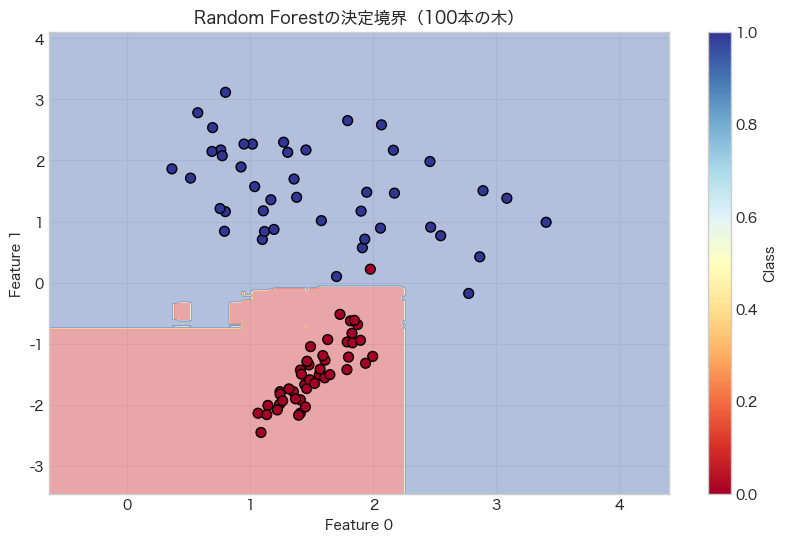


💡 ポイント: Random Forestの境界は単一の決定木より滑らか


In [25]:
# Random Forestの決定境界
plot_decision_boundary(rf, X_test, y_test, 'Random Forestの決定境界（100本の木）')

print("\n💡 ポイント: Random Forestの境界は単一の決定木より滑らか")

### 3.3 木の数（n_estimators）の影響

🔄 異なる木の数で実験中...


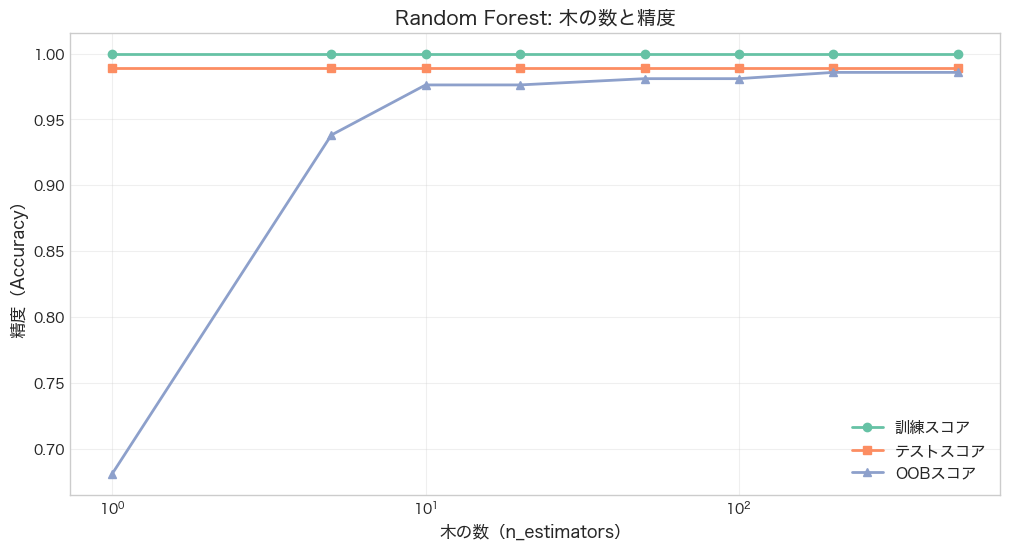


💡 重要なポイント:
   - 木の数が増えると精度が安定する
   - 過学習しにくい（訓練とテストの差が小さい）
   - 100本程度で十分な場合が多い


In [26]:
# 木の数を変えて実験
n_estimators_list = [1, 5, 10, 20, 50, 100, 200, 500]
train_scores_rf = []
test_scores_rf = []
oob_scores_rf = []

print("🔄 異なる木の数で実験中...")
for n_est in n_estimators_list:
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=5,
        oob_score=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    train_scores_rf.append(rf_temp.score(X_train, y_train))
    test_scores_rf.append(rf_temp.score(X_test, y_test))
    oob_scores_rf.append(rf_temp.oob_score_)

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_list, train_scores_rf, 'o-', label='訓練スコア', linewidth=2)
plt.plot(n_estimators_list, test_scores_rf, 's-', label='テストスコア', linewidth=2)
plt.plot(n_estimators_list, oob_scores_rf, '^-', label='OOBスコア', linewidth=2)
plt.xscale('log')
plt.xlabel('木の数（n_estimators）', fontsize=12)
plt.ylabel('精度（Accuracy）', fontsize=12)
plt.title('Random Forest: 木の数と精度', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n💡 重要なポイント:")
print(f"   - 木の数が増えると精度が安定する")
print(f"   - 過学習しにくい（訓練とテストの差が小さい）")
print(f"   - 100本程度で十分な場合が多い")

## ⚡ 4. Gradient Boosting基礎

### Gradient Boostingとは？

Gradient Boostingは、**前の木の間違いを次の木で修正していく**手法です。
「失敗から学ぶ」というアプローチで、**逐次的に弱い学習器を追加**して精度を高めます。

---

### 🔄 Random Forest vs Gradient Boosting

```
Random Forest（バギング）:
  木1 ─┐
  木2 ─┼─→ 多数決/平均 → 最終予測
  木3 ─┤
  木4 ─┘
  
  各木は「独立」に並列で訓練
  → 分散（バリアンス）を減らす

Gradient Boosting（ブースティング）:
  木1 → 残差計算 → 木2 → 残差計算 → 木3 → ... → 合計 → 最終予測
  
  各木は「前の木の間違い」を学習
  → バイアスを減らす
```

---

### 🎯 残差学習の仕組み（具体例）

住宅価格を予測する例で説明します。

```
実際の価格: [100万, 200万, 150万, 300万, 250万]

【ステップ1: 最初の予測】
  初期予測 = 平均値 = 200万（全員に同じ値を予測）
  
  残差（誤差）:
    サンプル1: 100 - 200 = -100（予測が100万高すぎ）
    サンプル2: 200 - 200 = 0（ぴったり）
    サンプル3: 150 - 200 = -50（予測が50万高すぎ）
    サンプル4: 300 - 200 = +100（予測が100万低すぎ）
    サンプル5: 250 - 200 = +50（予測が50万低すぎ）

【ステップ2: 1本目の木で残差を学習】
  残差 [-100, 0, -50, +100, +50] を予測する木を訓練
  
  木1の予測: [-80, +10, -40, +90, +40]（完璧ではない）
  
  更新後の予測 = 200 + 0.1 × 木1の予測  ← 学習率0.1で少しずつ修正
    サンプル1: 200 + 0.1×(-80) = 192万
    サンプル2: 200 + 0.1×(+10) = 201万
    ...

【ステップ3: 新しい残差を計算】
  新残差 = 実際の価格 - 更新後の予測
    サンプル1: 100 - 192 = -92（まだ高い）
    ...

【ステップ4: 2本目の木で新残差を学習】
  ...繰り返し...

【最終予測】
  f(x) = 初期値 + η×木1(x) + η×木2(x) + ... + η×木M(x)
```

---

### 📐 なぜ「勾配（Gradient）」ブースティング？

**損失関数の勾配（微分）方向に予測を更新**するからです。

```
損失関数 L(y, f(x)) の最小化:

  MSE（二乗誤差）の場合:
    L = (y - f(x))²
    ∂L/∂f = -2(y - f(x)) = -2 × 残差
    
    → 残差方向に更新 = 勾配降下法と同じ！

  一般化:
    - 任意の損失関数に対応可能
    - 分類: ログ損失（クロスエントロピー）
    - 回帰: MSE, MAE, Huber損失など
```

**勾配降下法との類似性**:
```
ニューラルネットワーク: 重みを勾配方向に更新
  w ← w - η × ∂L/∂w

Gradient Boosting: 予測を勾配方向に更新（新しい木で）
  f(x) ← f(x) + η × h(x)  ← h(x)は残差（勾配）を予測する木
```

---

### 🎛️ 学習率（learning_rate）の役割

```
学習率 η が大きい（例: 1.0）:
  f(x) = 初期値 + 1.0×木1 + 1.0×木2 + ...
  
  ✓ 少ない木で収束
  ✗ 各木の寄与が大きすぎて過学習しやすい
  ✗ 最適解を飛び越える可能性

学習率 η が小さい（例: 0.01）:
  f(x) = 初期値 + 0.01×木1 + 0.01×木2 + ...
  
  ✓ 慎重に学習、過学習しにくい
  ✓ より滑らかな予測
  ✗ 多くの木が必要（計算時間増）
```

**実践的なトレードオフ**:
```
小さい学習率（0.01-0.1） + 多い木（500-5000本）
  → 高精度、過学習しにくい、計算時間長い

大きい学習率（0.1-0.3） + 少ない木（100-300本）
  → そこそこの精度、高速、過学習リスクあり

推奨: learning_rate=0.05-0.1, n_estimators=200-500
```

---

### 📊 Random Forest vs Gradient Boosting 詳細比較

| 観点 | Random Forest | Gradient Boosting |
|------|---------------|-------------------|
| **訓練方法** | 並列（独立） | 逐次（依存） |
| **何を減らす？** | 分散（バリアンス） | バイアス |
| **過学習** | しにくい | しやすい（要調整） |
| **計算速度** | 高速（並列化可能） | 遅い（逐次処理） |
| **メモリ** | 大きい（全木を保持） | 小さめ |
| **チューニング** | 簡単（デフォルトでOK） | 複雑（lr, n_estimators等） |
| **最高精度** | 良い | 非常に良い |
| **外れ値への耐性** | 強い | やや弱い |

**使い分けの目安**:
```
Random Forestを選ぶ場合:
  - ✓ まずベースラインとして試したい
  - ✓ 計算リソースが限られている
  - ✓ チューニングに時間をかけられない
  - ✓ 安定した結果が欲しい

Gradient Boostingを選ぶ場合:
  - ✓ 最高精度を追求したい
  - ✓ チューニングする時間がある
  - ✓ Kaggle等のコンペティション
  - ✓ 十分な計算リソースがある
```

---

### 主要なハイパーパラメータ

| パラメータ | 説明 | 推奨値 |
|-----------|------|--------|
| `n_estimators` | 木の数 | 100-1000（early stoppingと併用） |
| `learning_rate` | 学習率 | 0.01-0.1（小さいほど多くの木が必要） |
| `max_depth` | 木の最大深さ | 3-8（浅い木が一般的） |
| `min_samples_split` | 分割に必要な最小サンプル数 | 2-20 |
| `min_samples_leaf` | 葉に必要な最小サンプル数 | 1-10 |
| `subsample` | 各木で使うサンプル割合 | 0.5-1.0（< 1.0で過学習抑制） |
| `max_features` | 各分岐で使う特徴量数 | 'sqrt', 'log2', or 0.5-1.0 |

---

### 🚀 より高度なGBDT実装

scikit-learnの`GradientBoostingClassifier`は基本実装です。
実務では以下の高速・高精度な実装が使われます：

| ライブラリ | 特徴 | ノートブック |
|-----------|------|-------------|
| **LightGBM** | 高速、メモリ効率良い、カテゴリカル対応 | 13-14 |
| **XGBoost** | 高精度、正則化、欠損値対応 | 15 |
| **CatBoost** | カテゴリカルに強い、GPU対応 | 16 |

これらはノートブック13-16で詳しく学びます。

### 4.1 Gradient Boostingの訓練

📊 Gradient Boostingの結果:

訓練精度: 1.000
テスト精度: 0.989

木の数: 100
学習率: 0.1


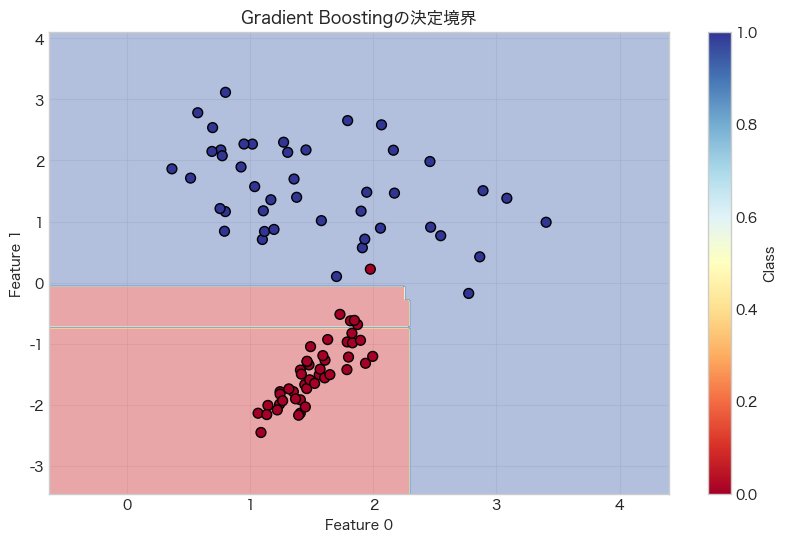

In [27]:
# Gradient Boostingモデル
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0,  # サブサンプリング率（1.0 = 全データ使用）
    random_state=RANDOM_STATE
)
gb.fit(X_train, y_train)

# 予測
y_train_pred_gb = gb.predict(X_train)
y_test_pred_gb = gb.predict(X_test)

# 評価
train_acc_gb = accuracy_score(y_train, y_train_pred_gb)
test_acc_gb = accuracy_score(y_test, y_test_pred_gb)

print("📊 Gradient Boostingの結果:")
print(f"\n訓練精度: {train_acc_gb:.3f}")
print(f"テスト精度: {test_acc_gb:.3f}")
print(f"\n木の数: {gb.n_estimators}")
print(f"学習率: {gb.learning_rate}")

# 決定境界
plot_decision_boundary(gb, X_test, y_test, 'Gradient Boostingの決定境界')

### 4.2 学習率（learning_rate）の影響

🔄 異なる学習率で実験中...


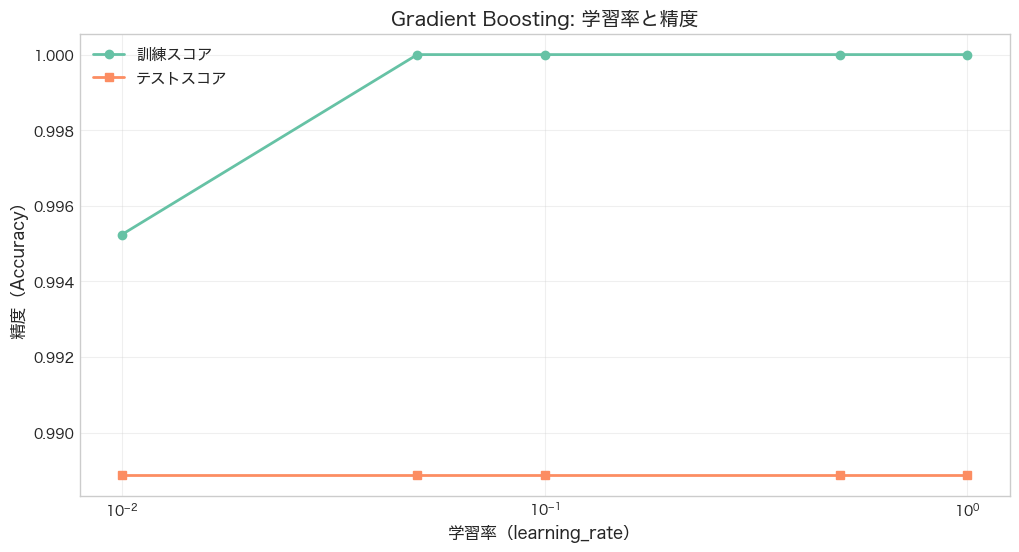


💡 学習率のトレードオフ:
   - 小さい（例: 0.01）: 慎重に学習、多くの木が必要、過学習しにくい
   - 大きい（例: 1.0）: 素早く学習、少ない木でOK、過学習しやすい
   - 推奨: 0.05-0.1程度


In [28]:
# 異なる学習率で実験
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
train_scores_gb = []
test_scores_gb = []

print("🔄 異なる学習率で実験中...")
for lr in learning_rates:
    gb_temp = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=RANDOM_STATE
    )
    gb_temp.fit(X_train, y_train)
    train_scores_gb.append(gb_temp.score(X_train, y_train))
    test_scores_gb.append(gb_temp.score(X_test, y_test))

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(learning_rates, train_scores_gb, 'o-', label='訓練スコア', linewidth=2)
plt.plot(learning_rates, test_scores_gb, 's-', label='テストスコア', linewidth=2)
plt.xscale('log')
plt.xlabel('学習率（learning_rate）', fontsize=12)
plt.ylabel('精度（Accuracy）', fontsize=12)
plt.title('Gradient Boosting: 学習率と精度', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 学習率のトレードオフ:")
print("   - 小さい（例: 0.01）: 慎重に学習、多くの木が必要、過学習しにくい")
print("   - 大きい（例: 1.0）: 素早く学習、少ない木でOK、過学習しやすい")
print("   - 推奨: 0.05-0.1程度")

## 📊 5. モデル比較

決定木、Random Forest、Gradient Boostingを総合的に比較します。


📊 モデル比較結果:


,Model,Train Acc,Test Acc,CV Acc (mean),CV Acc (std),Overfit
0,Decision Tree,1.0,0.988889,0.983333,0.014907,0.011111
1,Random Forest,1.0,0.988889,0.986667,0.012472,0.011111
2,Gradient Boosting,1.0,0.988889,0.983333,0.014907,0.011111


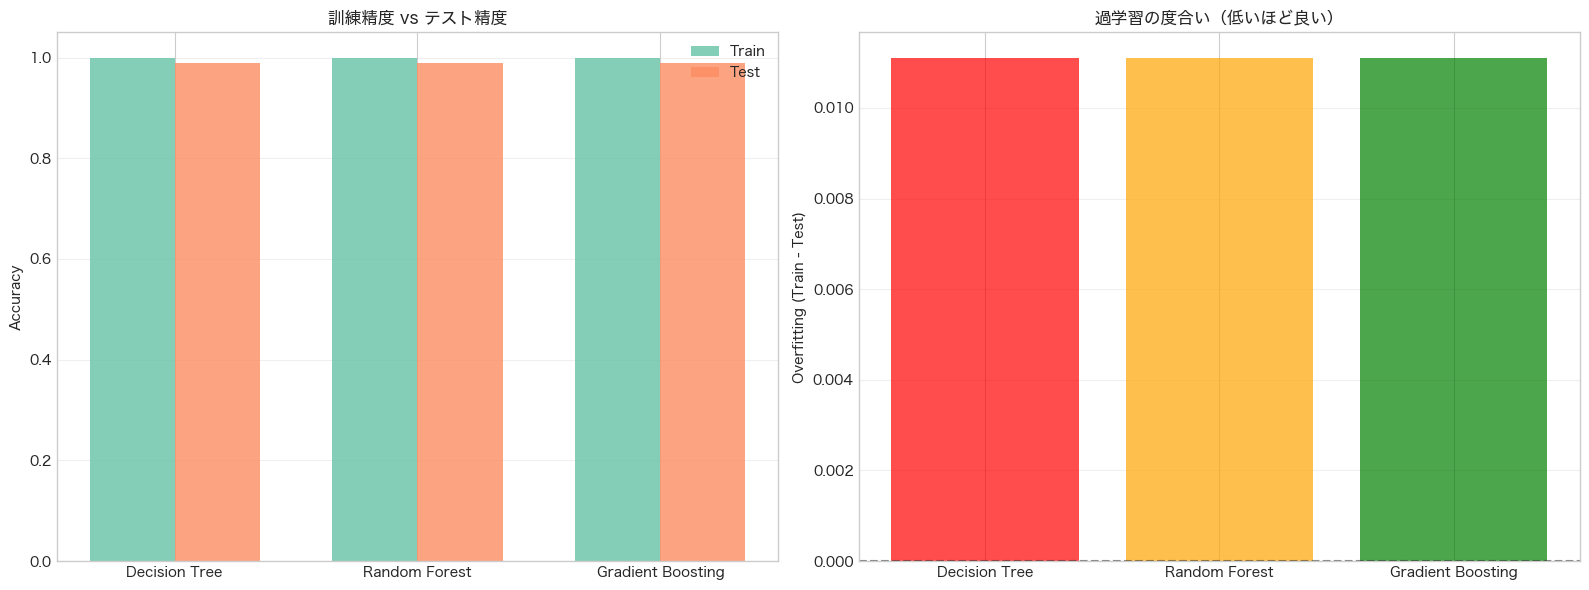


💡 まとめ:
   最高テスト精度: Decision Tree
   最小過学習: Decision Tree


In [29]:
# 3つのモデルを同じデータで訓練・評価
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
}

results = []
for name, model in models.items():
    # 訓練
    model.fit(X_train, y_train)
    
    # 評価
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Cross-Validation
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    results.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'CV Acc (mean)': cv_scores.mean(),
        'CV Acc (std)': cv_scores.std(),
        'Overfit': train_acc - test_acc
    })

# 結果をDataFrameに
results_df = pd.DataFrame(results)
print("\n📊 モデル比較結果:")
display(results_df)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 精度比較
x = np.arange(len(results_df))
width = 0.35
axes[0].bar(x - width/2, results_df['Train Acc'], width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, results_df['Test Acc'], width, label='Test', alpha=0.8)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('訓練精度 vs テスト精度')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 過学習度
axes[1].bar(results_df['Model'], results_df['Overfit'], color=['red', 'orange', 'green'], alpha=0.7)
axes[1].set_ylabel('Overfitting (Train - Test)')
axes[1].set_title('過学習の度合い（低いほど良い）')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n💡 まとめ:")
best_model = results_df.loc[results_df['Test Acc'].idxmax(), 'Model']
print(f"   最高テスト精度: {best_model}")
print(f"   最小過学習: {results_df.loc[results_df['Overfit'].idxmin(), 'Model']}")

## 🏥 6. 実践例: Breast Cancer診断

実データでモデルを適用し、医療診断の精度を向上させます。

In [30]:
# Breast Cancerデータセット読み込み
data = load_breast_cancer()
X_cancer = data.data
y_cancer = data.target
feature_names_cancer = data.feature_names

print("🏥 Breast Cancer Dataset")
print(f"\nサンプル数: {X_cancer.shape[0]}")
print(f"特徴量数: {X_cancer.shape[1]}")
print(f"\nクラス分布:")
class_counts = pd.Series(y_cancer).value_counts()
print(f"   Malignant (悪性): {class_counts[0]} ({class_counts[0]/len(y_cancer)*100:.1f}%)")
print(f"   Benign (良性): {class_counts[1]} ({class_counts[1]/len(y_cancer)*100:.1f}%)")

# データ分割
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=RANDOM_STATE, stratify=y_cancer
)

print(f"\n訓練データ: {X_train_c.shape[0]} samples")
print(f"テストデータ: {X_test_c.shape[0]} samples")

🏥 Breast Cancer Dataset

サンプル数: 569
特徴量数: 30

クラス分布:
   Malignant (悪性): 212 (37.3%)
   Benign (良性): 357 (62.7%)

訓練データ: 398 samples
テストデータ: 171 samples


### 6.1 Random Forestで診断

📊 Random Forest診断結果:

精度: 0.942
AUC-ROC: 0.992

詳細レポート:
              precision    recall  f1-score   support

   Malignant       0.94      0.91      0.92        64
      Benign       0.94      0.96      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



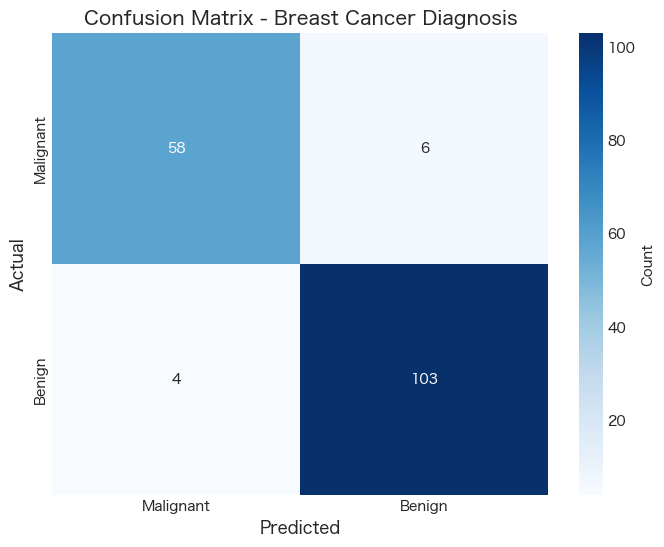


💡 医療診断での重要ポイント:
   - False Negative（悪性を良性と誤診）: 最も避けたい
   - False Positive（良性を悪性と誤診）: 不要な検査が増える
   - 現在のFalse Negative: 6 件
   - 現在のFalse Positive: 4 件


In [31]:
# Random Forestモデル
rf_cancer = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_cancer.fit(X_train_c, y_train_c)

# 予測
y_pred_c = rf_cancer.predict(X_test_c)
y_pred_proba_c = rf_cancer.predict_proba(X_test_c)[:, 1]

# 評価
print("📊 Random Forest診断結果:")
print(f"\n精度: {accuracy_score(y_test_c, y_pred_c):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test_c, y_pred_proba_c):.3f}")
print(f"\n詳細レポート:")
print(classification_report(y_test_c, y_pred_c, target_names=['Malignant', 'Benign']))

# Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'],
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix - Breast Cancer Diagnosis', fontsize=14)
plt.show()

print("\n💡 医療診断での重要ポイント:")
print("   - False Negative（悪性を良性と誤診）: 最も避けたい")
print("   - False Positive（良性を悪性と誤診）: 不要な検査が増える")
print(f"   - 現在のFalse Negative: {cm[0, 1]} 件")
print(f"   - 現在のFalse Positive: {cm[1, 0]} 件")

### 6.2 特徴量重要度の分析 ⭐⭐⭐

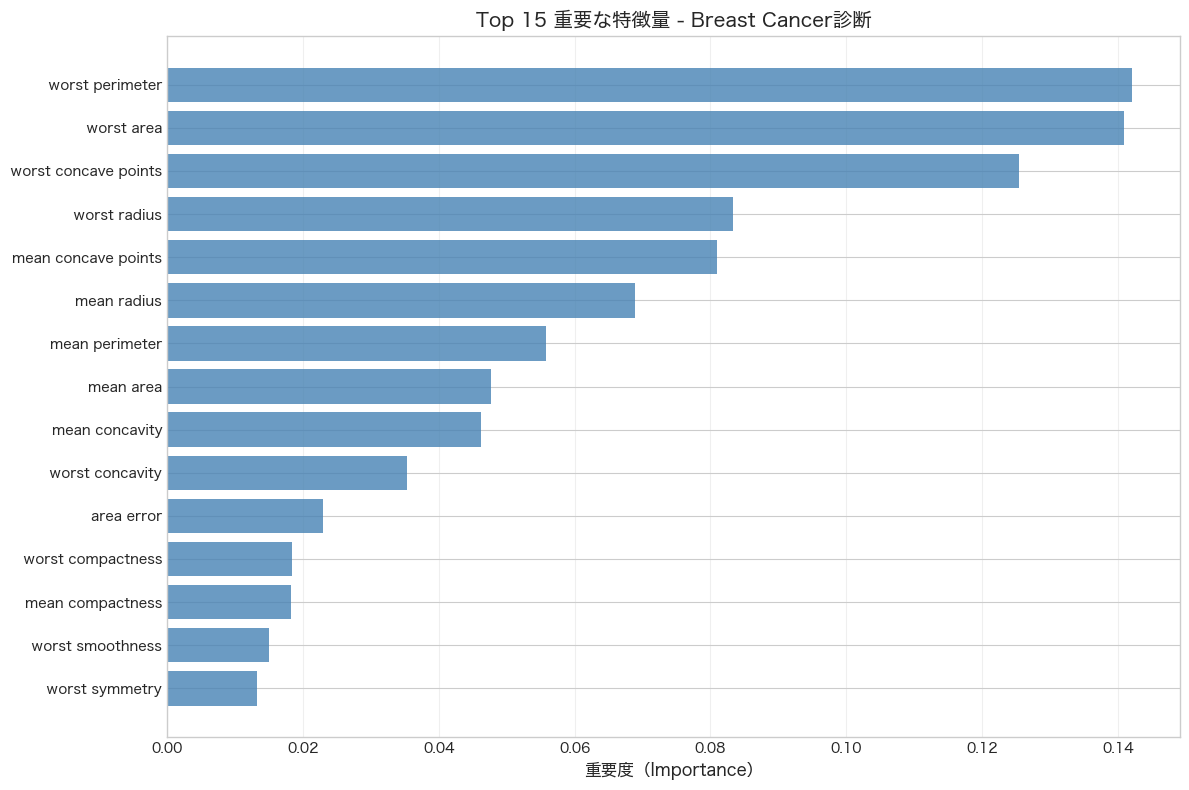


📊 Top 10 重要な特徴量:


,Feature,Importance
22,worst perimeter,0.142018
23,worst area,0.140808
27,worst concave points,0.125401
20,worst radius,0.083392
7,mean concave points,0.080999
0,mean radius,0.068950
2,mean perimeter,0.055822
3,mean area,0.047663
6,mean concavity,0.046193
26,worst concavity,0.035400



💡 特徴量重要度の活用:
   - 医師への説明: どの指標が診断に重要か
   - 特徴量選択: 重要度の低い特徴量を削除
   - モデルの解釈: ビジネスロジックの理解


In [32]:
# 特徴量重要度の取得
feature_importance = pd.DataFrame({
    'Feature': feature_names_cancer,
    'Importance': rf_cancer.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 15特徴量を可視化
top_features = feature_importance.head(15)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('重要度（Importance）', fontsize=12)
plt.title('Top 15 重要な特徴量 - Breast Cancer診断', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Top 10 重要な特徴量:")
display(top_features.head(10))

print("\n💡 特徴量重要度の活用:")
print("   - 医師への説明: どの指標が診断に重要か")
print("   - 特徴量選択: 重要度の低い特徴量を削除")
print("   - モデルの解釈: ビジネスロジックの理解")

### 6.3 ROC曲線

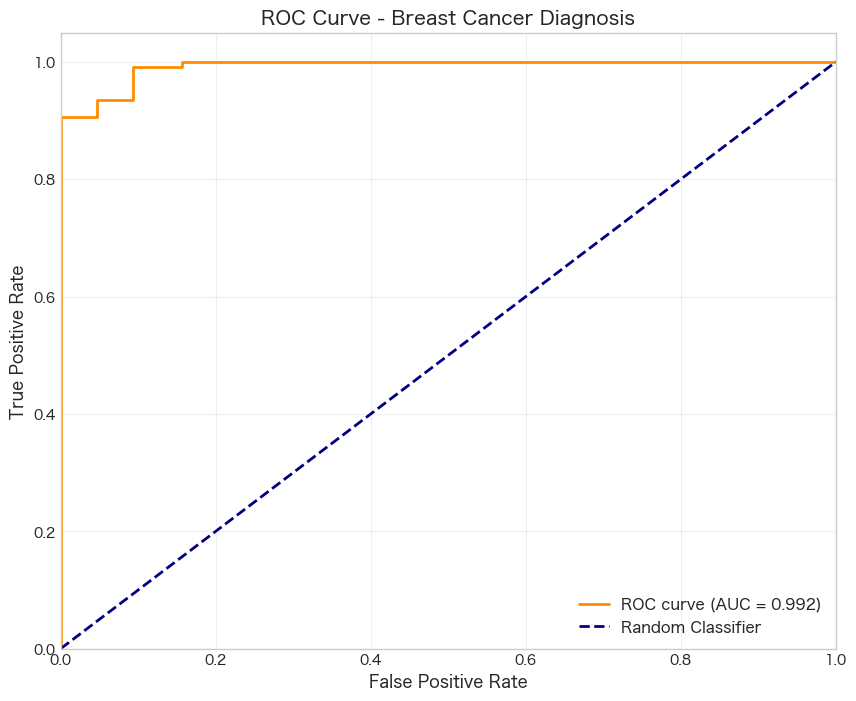


💡 ROC曲線の読み方:
   - AUC（曲線下面積）が1に近いほど良いモデル
   - 現在のAUC: 0.992 → 優秀
   - ランダム分類器（点線）より大幅に上


In [33]:
# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_proba_c)
roc_auc = roc_auc_score(y_test_c, y_pred_proba_c)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Breast Cancer Diagnosis', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 ROC曲線の読み方:")
print("   - AUC（曲線下面積）が1に近いほど良いモデル")
print(f"   - 現在のAUC: {roc_auc:.3f} → {'優秀' if roc_auc > 0.9 else '良好'}")
print("   - ランダム分類器（点線）より大幅に上")

### 6.4 ハイパーパラメータチューニング

In [34]:
# GridSearchCVでパラメータ探索
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

print("\n🔍 GridSearchCV実行中...")
print(f"   探索するパラメータ組み合わせ: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])}")

grid_search.fit(X_train_c, y_train_c)

print(f"\n✅ 最適なパラメータ:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n最高CVスコア: {grid_search.best_score_:.4f}")
print(f"テストスコア: {grid_search.score(X_test_c, y_test_c):.4f}")

# 最良モデルの詳細評価
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_c)

print(f"\n最適化後の詳細レポート:")
print(classification_report(y_test_c, y_pred_best, target_names=['Malignant', 'Benign']))


🔍 GridSearchCV実行中...
   探索するパラメータ組み合わせ: 48

✅ 最適なパラメータ:
   max_depth: 5
   max_features: sqrt
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 100

最高CVスコア: 0.9725
テストスコア: 0.9415

最適化後の詳細レポート:
              precision    recall  f1-score   support

   Malignant       0.94      0.91      0.92        64
      Benign       0.94      0.96      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



## 🎓 7. まとめ

### 学んだこと

1. ✅ **決定木**
   - if-thenルールで解釈しやすい
   - 過学習しやすいため深さ制御が重要
   - 非線形パターンをモデル化可能

2. ✅ **Random Forest**
   - バギング + ランダム特徴量選択
   - 過学習しにくく、高精度
   - 並列処理可能で高速
   - 特徴量重要度が得られる

3. ✅ **Gradient Boosting**
   - 逐次的に木を追加
   - 高精度だが調整が必要
   - 学習率とのトレードオフ

4. ✅ **実践的なテクニック**
   - GridSearchCVでパラメータ最適化
   - Cross-Validationで汎化性能評価
   - 特徴量重要度で解釈性向上

### モデルの使い分け

| モデル | 利点 | 欠点 | 推奨用途 |
|--------|------|------|----------|
| **決定木** | 解釈しやすい<br>高速 | 過学習しやすい<br>不安定 | 探索的分析<br>ベースライン |
| **Random Forest** | 安定<br>高精度<br>並列化可能 | 解釈性やや低い<br>メモリ消費大 | 一般的な分類・回帰<br>特徴量選択 |
| **Gradient Boosting** | 最高精度<br>柔軟性高い | 調整が複雑<br>過学習リスク | コンペティション<br>精度重視タスク |

### 次のステップ

- **ノートブック06**: SVM とカーネル法
- **ノートブック13-16**: 高度なGBDT（LightGBM、XGBoost、CatBoost）
  - より高速なアルゴリズム
  - カテゴリカル変数の直接処理
  - GPU対応
  - Kaggleで頻繁に使用される

### 重要なポイント

💡 **いつ使うべきか？**
- テーブルデータ（表形式データ）
- 特徴量が多い場合
- 非線形な関係がある場合
- 解釈性と精度の両方が必要な場合

⚠️ **注意点**
- 画像・音声・テキストには不向き（ディープラーニング推奨）
- データが少ない場合は線形モデルも検討
- 計算リソースを考慮（Random Forestは並列化可能）

---

**🎉 お疲れ様でした！決定木とアンサンブルの基礎から実践までマスターしました！**

## 📝 練習問題

### 問題1: 基礎知識
1. Random ForestとGradient Boostingの違いを説明してください
2. なぜRandom Forestは過学習しにくいのですか？
3. Gini不純度とエントロピーの違いは何ですか？

### 問題2: 実装
1. Wineデータセット（`load_wine()`）でRandom Forestを訓練してください
2. GridSearchCVを使って最適なパラメータを見つけてください
3. 特徴量重要度を可視化し、上位5つの特徴量を特定してください

### 問題3: 発展
1. `max_features`パラメータを変えて、モデルの精度がどう変わるか実験してください
2. Random ForestとGradient Boostingで同じデータセットを比較し、どちらが良いか考察してください
3. 学習曲線（Learning Curve）をプロットして、モデルの改善余地を分析してください

---

## 🔗 参考リンク

- [scikit-learn Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [scikit-learn Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [scikit-learn Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Understanding Random Forests](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)

---

**Happy Learning! 🌳**